In [49]:
import math
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from geant3_parser import build_train_set
from geant3_parser import Geant3DataFile
import os

In [50]:
def get_bin_centers(bins):
    """Calculates bin centers out of bin boundaries"""
    assert len(bins) >= 2
    return bins[:-1] + (bins[1:] - bins[:-1]) / 2

def histo_rms(histo, bins):
    """Root mean squares from histogram"""
    bin_centers = get_bin_centers(bins)

    rms = np.sum(histo*(bin_centers*bin_centers))/np.sum(histo)
    rms = math.sqrt(rms)
    return rms

# Some constants with calorimeter information
max_cell_index = 5
total_columns = max_cell_index * 2 + 1
total_rows = total_columns              # square calorimeter

In [51]:
# Load data model from saved HD5 file
model = load_model('g3_dense_with_xy.hd5')

In [52]:
# Open data file
file_name = os.path.join('data', 'shower_geant3_new.dat')
data_file = Geant3DataFile(file_name, skip_lines=3)
input_data, true_e, sum_e = build_train_set(data_file, 50000, add_real_xy=True)

# Run ML on data
eval_e = model.predict(input_data)

# Flatten arrays, so it is easy to build histograms
eval_e = eval_e.flatten()
true_e = true_e.flatten()
sum_e = sum_e.flatten()

Time open 1.898725986480713
Time split 0.40236592292785645


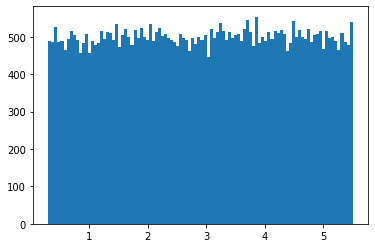

In [53]:
plt.hist(true_e, bins=100)
plt.show()

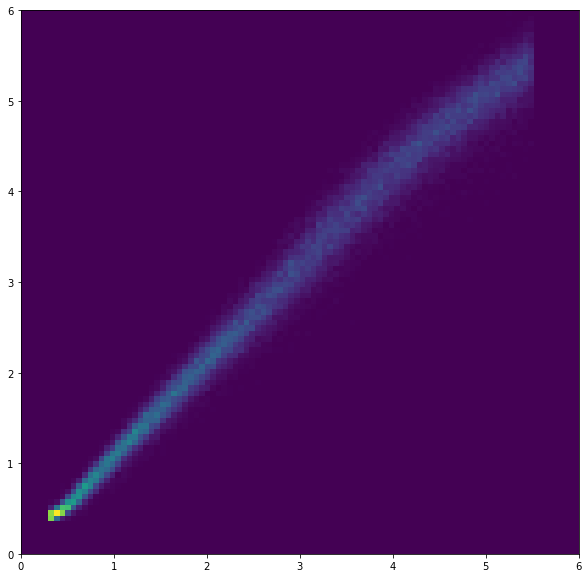

In [54]:
# Plot true Energy vs reconstructed
plt.figure(figsize=(10, 10))
plt.hist2d(true_e, eval_e, bins=100, range=[[0, 6], [0, 6]])
plt.show()

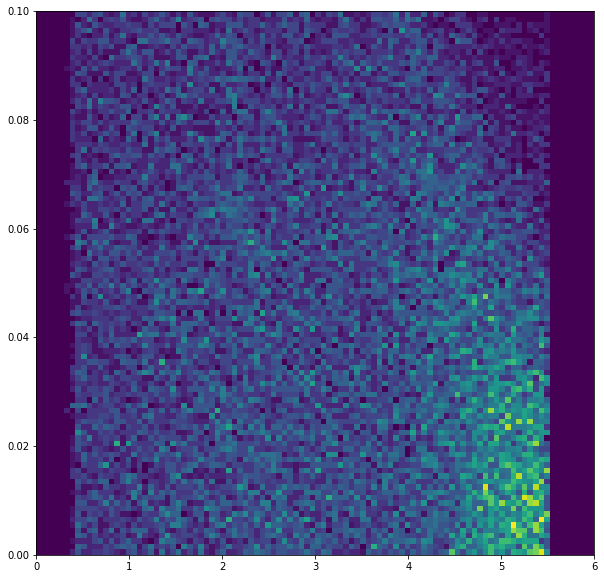

In [55]:
# Calculate square root difference vs true_e
eval_dee = np.sqrt(np.power((true_e - eval_e), 2)) / true_e
mask = np.isfinite(eval_dee)
eval_dee = eval_dee[mask]
true_e = true_e[mask]
eval_e = eval_e[mask]
del mask

plt.figure(figsize=(10, 10))
plt.hist2d(true_e, eval_dee, bins=100, range=[[0, 6], [0, 0.1]])
plt.show()

C:\Users\espen\AppData\Local\Temp\ipykernel_8732\285248547.py:10: RuntimeWarning: invalid value encountered in double_scalars
  rms = np.sum(histo*(bin_centers*bin_centers))/np.sum(histo)


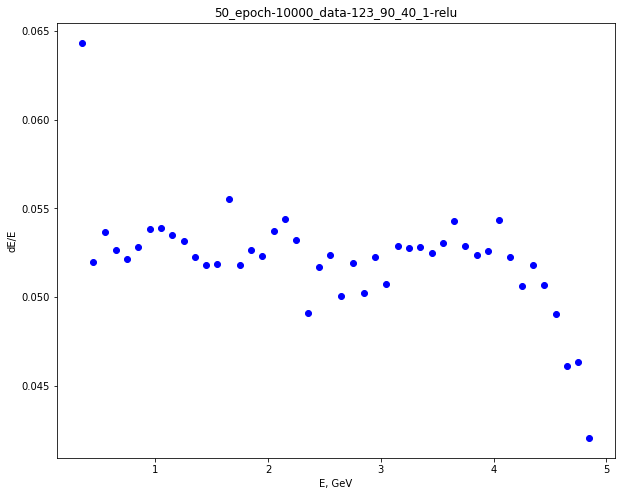

In [56]:
# Plot dE/E

# Build numpy 2d histogram
err_bins = np.arange(0, 0.1, 0.005)
e_bins = np.arange(0, 5, 0.1)
eval_dee_hist, _, _ = np.histogram2d(true_e, eval_dee, bins=[e_bins, err_bins])

# Get bin centers and slice data by bins
e_bin_centers = get_bin_centers(e_bins)
eval_rmses=[histo_rms(h1d, err_bins) for h1d in eval_dee_hist]

fig = plt.figure(figsize=(10, 8)) #, dpi=150)
ax = fig.add_subplot(111)
ax.plot(e_bin_centers, eval_rmses, 'bo')
ax.set_title('50_epoch-10000_data-123_90_40_1-relu')
ax.set_xlabel('E, GeV')
ax.set_ylabel('dE/E')

del eval_dee, eval_dee_hist, eval_e
plt.show()